# **<ins>Project Topic</ins>**: Developing a Knowledge Distillation Pipeline for MNIST Digit Classification Using Supervised Deep Learning

## **<ins>Project Description</ins>**: This project involves using supervised deep learning, specifically knowledge distillation, to classify handwritten digits from the MNIST dataset. A “teacher” model (large convolutional network) is first trained to achieve high accuracy, and then a “student” model (smaller convolutional network) is trained to mimic the teacher’s outputs. The objective is to significantly reduce the computational resources and parameter count required for inference while maintaining accuracy levels close to that of the larger teacher model. This approach offers a practical solution to deploying neural networks in environments with limited memory or processing power.

In [1]:
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Description and Citation
# -----------------------------
 This project uses the MNIST dataset of handwritten digit images. It is accessed via TorchVision’s built-in MNIST class, which downloads the dataset automatically. MNIST is a public dataset commonly used for benchmarking image classification algorithms. APA-style reference:

 LeCun, Y., Cortes, C., & Burges, C. J. (1998).

 The MNIST database of handwritten digits.
 Retrieved from http://yann.lecun.com/exdb/mnist/

Data Description:

- This project uses the MNIST dataset from torchvision.
- MNIST contains 70,000 grayscale images in total (60,000 training samples and 10,000 testing samples).
- Each image is 28×28 pixels (1 channel, grayscale).
- All images are consistently sized (28×28).
- The total size is approximately 20 MB (downloaded from the MNIST dataset source).
- The training set is typically referred to as “train_dataset” and the test set as “test_dataset.”

• Image Data:  
  - Number of samples: 60,000 for training, 10,000 for testing  
  - Number of channels: 1 (grayscale)  
  - Modalities: Single modality (handwritten digit images)  
  - File format: Provided as part of torchvision MNIST (binary format, internally handled by PyTorch)  
  - Consistency: All images have the same resolution (28×28 pixels)
  
Additional Notes:  
• Data is loaded through PyTorch’s “datasets.MNIST.”  
• Data is split across two subsets (train/test).  
• Each sample belongs to one of 10 classes (digits 0 to 9).

In [34]:
batch_size = 256
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)
print("Length of train_loader: ", len(train_loader))
print("Length of test_loader: ", len(test_loader))

Length of train_loader:  235
Length of test_loader:  40


DATA CLEANING EXPLANATION

1) Checking for Data Issues:
   - Verify shapes, class distributions, potential missing data, or any corrupt images.
   - Since MNIST is a standard dataset, it rarely contains missing or malformed samples.

2) Short Explanation of MNIST Suitability:
   - MNIST is a well-known dataset of handwritten digits from 0–9 with 60,000 training
     images and 10,000 test images.
   - Each image is 28x28 pixels, grayscale, and consistently labeled.

3) Potential Drop/Imputation:
   - Normally, you would drop or impute if you had tabular data with NA values. MNIST
     does not contain such missing values.

4) Checking for Outliers:
   - For image data, “outliers” might manifest as mislabeled or corrupted images.
   - For MNIST, this is unlikely. However, you could visualize a sample batch to confirm.

5) Conclusion on Cleaning:
   - No significant cleaning steps required. The dataset is already suitable for training.

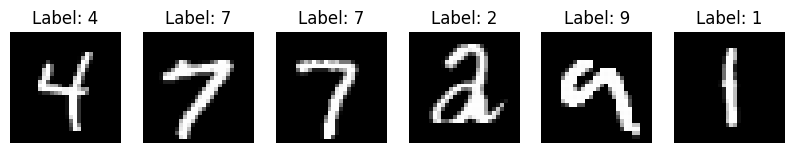

In [3]:
data_iter = iter(DataLoader(train_dataset, batch_size=6, shuffle=True))
images, labels = next(data_iter)

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 2))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.show()

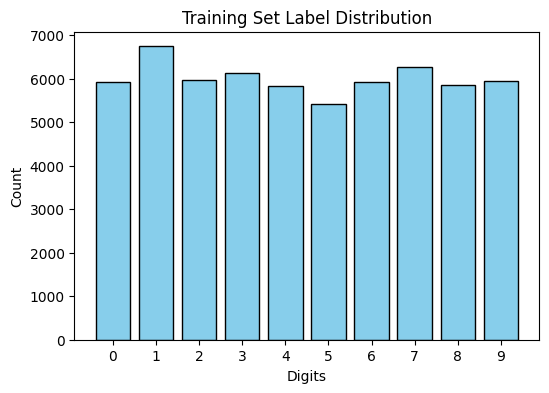

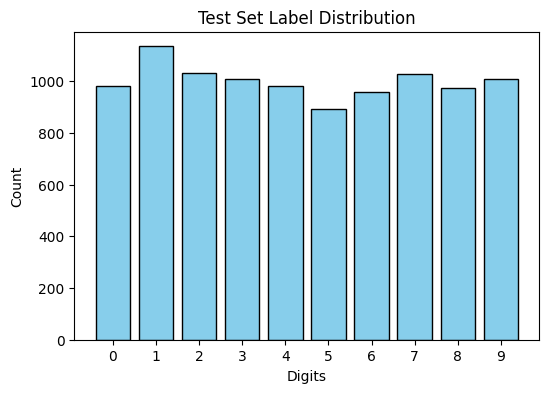

In [4]:
def plot_label_distribution(dataset, title="Label Distribution"):
    """
    Plots a histogram of labels in the given dataset.
    Helps visualize the distribution of classes (digits) in MNIST.
    """
    labels = [label for (img, label) in dataset]
    plt.figure(figsize=(6, 4))
    plt.hist(labels, bins=np.arange(11) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Digits')
    plt.ylabel('Count')
    plt.xticks(range(10))
    plt.show()

plot_label_distribution(train_dataset, "Training Set Label Distribution")
plot_label_distribution(test_dataset, "Test Set Label Distribution")

## Model Considerations
This script demonstrates:
1) Multiple Models:
   - Teacher (larger CNN)
   - Student (smaller CNN)
   - Student Clone (trained independently for comparison)

2) Advanced Technique: Knowledge Distillation
   - The student learns from the teacher’s softened outputs, improving accuracy.

3) Regularization & Training Techniques:
   - L2 weight decay to reduce overfitting
   - Learning Rate Schedulers for dynamic learning rate reduction

Other considerations:
- Appropriateness of Model(s): CNNs are well-suited for image classification tasks.  
- Feature Interaction & Collinearity: For CNNs handling raw images, collinearity is less of a concern compared to tabular data.  
- Model Diversity: Teacher, Student, and Student Clone.  
- Feature Importance: Not explicitly shown here, but methods like Grad-CAM could be applied for CNN interpretability.  
- Overfitting: Addressed with L2 regularization (weight decay) and reduced architecture for Student network.  
- Data Imbalance: MNIST is relatively balanced, so special techniques (e.g., SMOTE) are not used.  
- Innovation: Knowledge distillation (a technique not covered in basic classes) is employed.   

In [5]:
# Create the teacher
class Teacher(nn.Module):
  def __init__(self, num_classes=10):
    super(Teacher, self).__init__()
    # input_shape ~ [batch_size, 1, 28, 28]
    # shape ~ [batch_size, 256, 14, 14]
    self.conv_1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    # shape ~ [batch_size, 256, 14, 14]
    self.lr_1 = nn.LeakyReLU(inplace=True)
    # shape ~ [batch_size, 256, 15, 15]
    self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    # shape ~ [batch_size, 512, 8, 8]
    self.conv_2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    # shape ~ [batch_size, 10]
    self.lin_1 = nn.Linear(in_features=512 * 8 * 8, out_features=10)

  def forward(self, x):
    x = self.conv_1(x)
    x = F.leaky_relu(x)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = x.view(x.size(0), -1)
    x = self.lin_1(x)
    return x

In [6]:
# Create Student
class Student(nn.Module):
  def __init__(self, num_classes=10):
    super(Student, self).__init__()
    self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

    self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))

    self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

    self.lin_1 = nn.Linear(in_features=32 * 8 * 8, out_features=10)

  def forward(self, x):
    x = self.conv_1(x)
    x = F.leaky_relu(x)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = x.view(x.size(0), -1)
    x = self.lin_1(x)
    return x

In [7]:
teacher = Teacher(num_classes=10)
student = Student(num_classes=10)
student = student.to(device)
teacher = teacher.to(device)
total_params_t = sum(p.numel() for p in teacher.parameters())
total_params_s = sum(p.numel() for p in student.parameters())
print("Total Parameters in Teacher: ", total_params_t)
print("Total Parameters in Student: ", total_params_s)

Total Parameters in Teacher:  1510410
Total Parameters in Student:  25290


In [8]:
# Creating a clone of student
student_clone = Student(num_classes=10)

In [9]:
# Train Teacher
optimizer_t = torch.optim.Adam(teacher.parameters(), lr=0.0001)
loss_t = nn.CrossEntropyLoss()

teacher_train_losses = []
teacher_test_losses = []
teacher_test_accuracies = []

def compute_loss(model, data_loader, loss_generic, device):
  tot = 0.
  model.eval()
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)
    logits = model(features)
    loss = loss_generic(logits, targets)
    tot += loss.item()
  return tot/len(data_loader)

def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            probas = F.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100


EPOCHS = 4
start_time = time.time()
for epoch in range(EPOCHS):
  teacher.train()
  for batch_idx, (features, targets) in enumerate(train_loader):
    features = features.to(device)
    targets = targets.to(device)

    optimizer_t.zero_grad()
    logits = teacher(features)
    loss = loss_t(logits, targets)

    # LOGGING
    if batch_idx % 200 == 0:
      print("Batch: %03d/%03d" % (batch_idx, len(train_loader)))

    loss.backward()
    optimizer_t.step()
  teacher.eval()
  with torch.set_grad_enabled(False):
    train_average_loss = compute_loss(teacher, train_loader, loss_t, device)
    test_average_loss = compute_loss(teacher, test_loader, loss_t, device)
    test_accuracy = compute_accuracy(teacher, test_loader, device)
    print("Epoch: %03d/%03d | Teacher Train Loss: %.3f | Teacher Test Loss: %.3f | Teacher Test Accuracy: %.2f" % (epoch+1, EPOCHS, train_average_loss, test_average_loss, test_accuracy))
    teacher_train_losses.append(train_average_loss)
    teacher_test_losses.append(test_average_loss)
    teacher_test_accuracies.append(test_accuracy)
  epoch_elapsed_time = time.time() - start_time
  print("Epoch Elapsed Time: ", epoch_elapsed_time)
total_training_time = time.time() - start_time
print("Total Training Time: ", total_training_time)

Batch: 000/235
Batch: 200/235
Epoch: 001/004 | Teacher Train Loss: 0.228 | Teacher Test Loss: 0.215 | Teacher Test Accuracy: 93.74
Epoch Elapsed Time:  23.73592495918274
Batch: 000/235
Batch: 200/235
Epoch: 002/004 | Teacher Train Loss: 0.113 | Teacher Test Loss: 0.103 | Teacher Test Accuracy: 97.01
Epoch Elapsed Time:  44.62333822250366
Batch: 000/235
Batch: 200/235
Epoch: 003/004 | Teacher Train Loss: 0.079 | Teacher Test Loss: 0.075 | Teacher Test Accuracy: 97.71
Epoch Elapsed Time:  65.49603056907654
Batch: 000/235
Batch: 200/235
Epoch: 004/004 | Teacher Train Loss: 0.067 | Teacher Test Loss: 0.063 | Teacher Test Accuracy: 97.98
Epoch Elapsed Time:  87.2922101020813
Total Training Time:  87.29237580299377


In [27]:
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plot a confusion matrix using seaborn heatmap."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_metrics(train_losses, test_losses, test_accuracies, label="Model"):
    """Plot the training/test loss and test accuracy curves."""
    train_losses = [x.cpu().numpy() for x in train_losses if not isinstance(x, float)]
    test_losses = [x.cpu().numpy() for x in test_losses if not isinstance(x, float)]
    test_accuracies = [x.cpu().numpy() for x in test_accuracies if not isinstance(x, float)]
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.title(f'{label} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_accuracies, label='Test Accuracy (%)')
    plt.title(f'{label} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [28]:
def evaluate_model_metrics(model, data_loader, device):
    """
    Gather deeper evaluation metrics: confusion matrix, classification report,
    and F1 score (macro-averaged).
    """
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            logits = model(features)
            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    # Compute confusion matrix, classification report, F1
    cm = confusion_matrix(all_targets, all_preds)
    report = classification_report(all_targets, all_preds, digits=3)
    f1 = f1_score(all_targets, all_preds, average='macro')
    return cm, report, f1

====== Teacher Model - Results and Analysis ======
Teacher Confusion Matrix:
 [[ 975    0    0    0    0    1    1    1    2    0]
 [   0 1127    3    1    0    0    2    0    2    0]
 [   4    4 1011    1    2    0    1    4    5    0]
 [   1    0    4  994    1    2    0    1    3    4]
 [   1    0    0    0  976    0    0    0    2    3]
 [   3    0    0    4    0  877    3    1    2    2]
 [   7    3    1    0    5    2  937    0    3    0]
 [   1    7   21    4    5    1    0  970    3   16]
 [   3    0    4    2    3    1    0    2  953    6]
 [   5    4    0    1   12    2    0    4    3  978]]


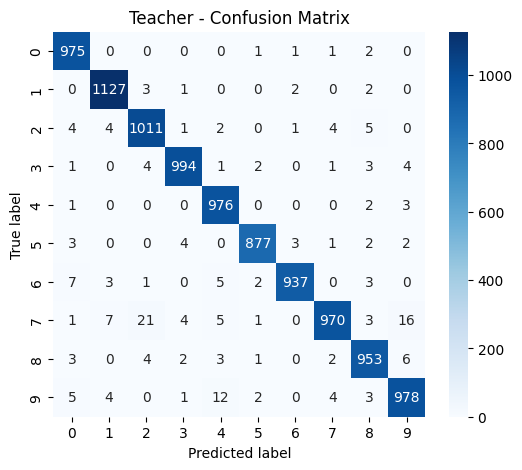

Teacher Classification Report:
               precision    recall  f1-score   support

           0      0.975     0.995     0.985       980
           1      0.984     0.993     0.989      1135
           2      0.968     0.980     0.974      1032
           3      0.987     0.984     0.986      1010
           4      0.972     0.994     0.983       982
           5      0.990     0.983     0.987       892
           6      0.993     0.978     0.985       958
           7      0.987     0.944     0.965      1028
           8      0.974     0.978     0.976       974
           9      0.969     0.969     0.969      1009

    accuracy                          0.980     10000
   macro avg      0.980     0.980     0.980     10000
weighted avg      0.980     0.980     0.980     10000

Teacher F1 Score (Macro): 0.980
--------------------------------------------------



In [31]:
print("====== Teacher Model - Results and Analysis ======")
# plot_metrics(teacher_train_losses, teacher_test_losses, teacher_test_accuracies, label="Teacher")

cm_teacher, report_teacher, f1_teacher = evaluate_model_metrics(teacher, test_loader, device)
print("Teacher Confusion Matrix:\n", cm_teacher)
plot_confusion_matrix(cm_teacher, title="Teacher - Confusion Matrix")

print("Teacher Classification Report:\n", report_teacher)
print(f"Teacher F1 Score (Macro): {f1_teacher:.3f}")
print("--------------------------------------------------\n")

In [32]:
# Create distil training
optimizer_distil = torch.optim.Adam(student.parameters(), lr=1e-3)
loss_s = nn.CrossEntropyLoss()
loss_distil = nn.KLDivLoss(reduction='batchmean')
alpha = 0.1
temperature = 5
EPOCHS = 5

# Freezing the layers of Teacher
teacher.eval()
for parameter in teacher.parameters():
    parameter.requires_grad = False

start_time = time.time()
for epoch in range(EPOCHS):
  student.train()
  for batch_idx, (features, targets) in enumerate(train_loader):
    features = features.to(device)
    targets = targets.to(device)

    teacher_logits = teacher(features)
    teacher_probs = F.softmax(teacher_logits / temperature, dim=1)

    optimizer_distil.zero_grad()
    student_logits = student(features)

    student_loss = loss_s(student_logits, targets)
    distillation_loss = loss_distil(F.log_softmax(input=(student_logits/temperature), dim=1), teacher_probs * (temperature ** 2))
    loss = alpha * student_loss + (1 - alpha) * distillation_loss

    # LOGGING
    if batch_idx % 200 == 0:
      print("Batch: %03d/%03d" % (batch_idx, len(train_loader)))

    loss.backward()
    optimizer_distil.step()

  student.eval()
  with torch.set_grad_enabled(False):
    train_average_loss = compute_loss(student, train_loader, loss_s, device)
    test_average_loss = compute_loss(student, test_loader, loss_s, device)
    test_accuracy = compute_accuracy(student, test_loader, device)
    print("Epoch: %03d/%03d | Student Train Loss: %.3f | Student Test Loss: %.3f | Student Test Accuracy: %.2f" % (epoch+1, EPOCHS, train_average_loss, test_average_loss, test_accuracy))
  epoch_elapsed_time = time.time() - start_time
  print("Epoch Elapsed Time: ", epoch_elapsed_time)
total_training_time = time.time() - start_time
print("Total Training Time: ", total_training_time)

Batch: 000/235
Batch: 200/235
Epoch: 001/005 | Student Train Loss: 0.346 | Student Test Loss: 0.316 | Student Test Accuracy: 90.65
Epoch Elapsed Time:  17.30937433242798
Batch: 000/235
Batch: 200/235
Epoch: 002/005 | Student Train Loss: 0.142 | Student Test Loss: 0.128 | Student Test Accuracy: 96.10
Epoch Elapsed Time:  31.269816398620605
Batch: 000/235
Batch: 200/235
Epoch: 003/005 | Student Train Loss: 0.099 | Student Test Loss: 0.090 | Student Test Accuracy: 97.27
Epoch Elapsed Time:  45.59600496292114
Batch: 000/235
Batch: 200/235
Epoch: 004/005 | Student Train Loss: 0.087 | Student Test Loss: 0.080 | Student Test Accuracy: 97.56
Epoch Elapsed Time:  59.376832723617554
Batch: 000/235
Batch: 200/235
Epoch: 005/005 | Student Train Loss: 0.082 | Student Test Loss: 0.074 | Student Test Accuracy: 97.69
Epoch Elapsed Time:  73.04312348365784
Total Training Time:  73.04340744018555


====== Distilled Student Model - Results and Analysis ======
Distilled Student Confusion Matrix:
 [[ 974    0    1    0    0    0    2    1    2    0]
 [   0 1124    3    3    0    0    3    0    2    0]
 [   4    2 1009    2    3    0    1    5    6    0]
 [   1    0    4  991    0    3    0    2    3    6]
 [   1    0    1    0  972    0    0    0    2    6]
 [   3    1    0    5    0  871    3    2    6    1]
 [   5    2    1    0    6    4  937    0    3    0]
 [   1    7   19    2    6    1    0  971    3   18]
 [   3    0    4    4    5    2    0    2  945    9]
 [   5    4    0    1   13    2    0    4    5  975]]


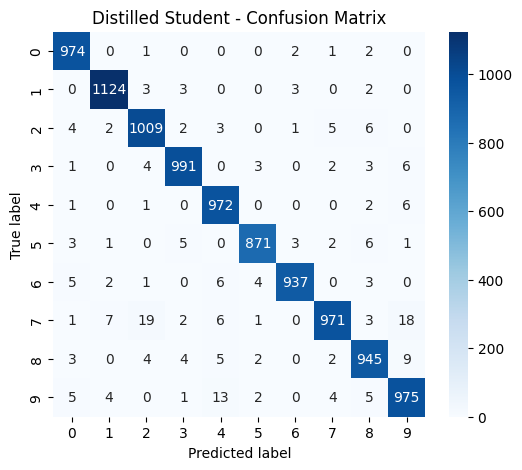

Distilled Student Classification Report:
               precision    recall  f1-score   support

           0      0.977     0.994     0.985       980
           1      0.986     0.990     0.988      1135
           2      0.968     0.978     0.973      1032
           3      0.983     0.981     0.982      1010
           4      0.967     0.990     0.978       982
           5      0.986     0.976     0.981       892
           6      0.990     0.978     0.984       958
           7      0.984     0.945     0.964      1028
           8      0.967     0.970     0.969       974
           9      0.961     0.966     0.963      1009

    accuracy                          0.977     10000
   macro avg      0.977     0.977     0.977     10000
weighted avg      0.977     0.977     0.977     10000

Distilled Student F1 Score (Macro): 0.977
--------------------------------------------------------------



In [33]:
print("====== Distilled Student Model - Results and Analysis ======")
# plot_metrics(student_train_losses, student_test_losses, student_test_accuracies, label="Student (Distilled)")

cm_student, report_student, f1_student = evaluate_model_metrics(student, test_loader, device)
print("Distilled Student Confusion Matrix:\n", cm_student)
plot_confusion_matrix(cm_student, title="Distilled Student - Confusion Matrix")

print("Distilled Student Classification Report:\n", report_student)
print(f"Distilled Student F1 Score (Macro): {f1_student:.3f}")
print("--------------------------------------------------------------\n")

## Discussion and Conclusion
1) Key Learnings and Takeaways:
   • This project successfully demonstrates knowledge distillation, where a larger
     Teacher model’s “knowledge” is transferred to a smaller Student model.
   • Despite having fewer parameters, the Student often achieves decent performance,
     illustrating the effectiveness of the distillation approach.
   • The code also compares a student that learns purely from data (student_clone)
     with a student that benefits from the teacher’s logits during training.

2) Why Something Might Not Work:
   • If the Teacher model is undertrained or overfitted, its “knowledge”
     could mislead the Student. Hence, ensuring the Teacher is well-trained
     is crucial.
   • The distillation hyperparameters, such as alpha and temperature, can
     significantly affect convergence and final accuracy. A suboptimal setting
     might yield poor results.

3) Suggested Ways to Improve:
   • Experiment with different temperatures (e.g., T=2, T=3) to find a balance
     in the smoothness of the Teacher’s output distribution.
   • Adjust the alpha parameter to control how much the Student relies on the
     Teacher’s distribution vs. the ground truth labels.
   • Incorporate data augmentation techniques or regularization (e.g., dropout)
     to improve generalization for both Teacher and Student.
   • Explore other network architectures (e.g., deeper Student or different layer
     types) and compare parameter counts, inference times, and performance.